In [1]:
import os
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodecsv as csv
import seaborn as sns
from collections import Counter
from cycler import cycler
from textwrap import wrap
from IPython.display import display, HTML, Markdown

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [3]:
from time import time
from IPython import get_ipython
import winsound

class Beeper:

    def __init__(self, threshold):
        self.threshold = threshold
        self.start_time = None    # time in sec, or None

    def pre_execute(self):
        if not self.start_time:
            self.start_time = time()

    def post_execute(self):
        end_time = time()
        if self.start_time and end_time - self.start_time > self.threshold:
            winsound.Beep(2500,1000)
        self.start_time = None


beeper = Beeper(60)

ipython = get_ipython()
ipython.events.register('pre_execute', beeper.pre_execute)
ipython.events.register('post_execute', beeper.post_execute)

In [4]:
%%html
<style>
div.float-bar-whh {
    z-index: 10;
    position: fixed;
    bottom: 5px;
    width: 540px;
    left: 50%;
    right: 50%;
    padding-right: 0px;
    padding-left: 0px;
    margin-left: -270px;
    background: #333;
    opacity: 0.7;
    box-shadow: 0 0 2px 0px black;
}
span.new-name-whh {
    height: 100%;
    line-height: 1em;
    margin: 16px 16px 16px 16px;
    border: none;
    font-size: 146.5%;
    color: white;
    text-overflow: ellipsis;
    overflow: hidden;
    white-space: nowrap;
    border-radius: 2px;
    opacity: 1;
}
</style>

<div class="float-bar-whh" style="display:block;">
    <center><span class="new-name-whh">Online Lenders</span></center>
</div>

# Analysize variables.

In [5]:
# Read documentation.
columns_file = r"../records_documentation.txt"

with open(columns_file,"r") as f:
    columns = f.readlines()
columns
        

['[Column 0] ID\n',
 '[Column 1] Birth year: deduced from education history, where available\n',
 '[Column 2] Gender flag: 1=female, 2=male, 0=unknown\n',
 '[Column 3] Skillset1: primary skillset deduced from self-reported skills\n',
 '[Column 4] Skillset1 weight: the extent to which primary skillset is representative of overall self-reported skills\n',
 '[Column 5] Skillset2: secondary skillset deduced from self-reported skills\n',
 '[Column 6] Skillset2 weight: the extent to which secondary skillset is representative of overall self-reported skills\n',
 '[Column 7] City of profile (does not change): where unavailable, the field is left blank\n',
 '[Column 8] Country of Profile (does not change)\n',
 '[Column 9] Education (highest degree attained): 0=none/unknown; 1=high school; 2=vocational degree; 3=associateÕs; 4=bachelorÕs; 5=masterÕs other than MBA; 6=MBA; 7=doctorate (PhD/JD/MD) [NB: Romanian names not covered]\n',
 "[Column 10] Elite institution: a flag indicating whether any o

So:
- Unique identifier: ID.
- Variable Groups:
    - Column 0-10, profile info; 
    - Column 11-28, employment or education info; (c26 = False or True)
        - Column 11-18, general info;
        - Column 19-25, company info;
        - Column 27-28, school info.

In [6]:
# Define an iterator for reading rows.
def rows_iter(index=True):
    if index:
        for index, line in enumerate(rows_iter(index=False)):
             yield index, line
    else:
        empl_file = r"../fin/finance_profiles.csv"
        with open(empl_file,"rb") as f:
            reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
            for line in reader:
                del line[1]
                yield line

In [7]:
# # Get unique values for each variable.
# unique_values = []
# for i in range(33):
#     unique_values.append(set())
# # Get unique values for each variable.
# for idx, line in rows_iter():
#     for i in range(33):
#         unique_values[i].add(line[i])
# for idx, values in enumerate(unique_values):
#     print("[Column {}] ".format(idx)+str(len(values)))

In [8]:
company_list = [
    ("Fairway Independent Mortgage", r"(?i)Fairway Independent Mortgage"),
    ("Flagstar Bank", r"(?i)Flagstar Bank"),
    ("United Wholesale Mortgage", r"(?i)United Wholesale Mortgage"),
    ("Caliber Home Loans", r"(?i)Caliber Home Loans"),
    ("loanDepot", r"(?i)loanDepot"),
    ("Quicken Loans (a.k.a Rocket Mortgage)", r"(?i)(Quicken Loans)|(Rocket Mortgage)"),
    ("PennyMac", r"(?i)PennyMac"),
    ("Guard Hill Financial", r"(?i)Guard ?Hill Financial"),
    ("Citadel Servicing", r"(?i)Citadel Servicing"),
    ("Nationstar Mortgage", r"(?i)Nationstar Mortgage"),
    ("PHH Mortgage", r"(?i)PHH Mortgage"),
    ("Angel Oak Mortgage Solutions", r"(?i)Angel Oak Mortgage Solutions"),
    ("HomeBridge Financial Services", r"(?i)HomeBridge Financial Services"),
    ("Caliber Home Loans", r"(?i)Caliber Home Loans"),
    ("Amerihome", r"(?i)Amerihome"),
    ("Freedom Mortgage", r"(?i)Freedom Mortgage"),
    ("newamerican funding", r"(?i)new ?american funding"),
    ("Reali loans", r"(?i)Reali loans"),
    ("Vylla", r"(?i)Vylla"),
    ("Northstar Funding", r"(?i)Northstar Funding"),
    ("Angel Oak Mortgage Solutions", r"(?i)Angel Oak Mortgage Solutions"),
    ("Athas Capital", r"(?i)Athas Capital"),
    ("JMAC Lending", r"(?i)JMAC Lending"),
    ("Carrington Mortgage Services", r"(?i)Carrington Mortgage Services"),
    ("Green Box Loans", r"(?i)Green ?Box Loans"),
    ("Oak Tree funding", r"(?i)Oak ?Tree funding"),
    ("First National Bank of America", r"(?i)First National Bank of America")
]

In [9]:
# # Get unique values for "ticker-naics-ticcode" tuple.
# unique_tuples = set()
# for idx, line in rows_iter():
#     if idx == -1:
#         break
#     if line[25] is not None and len(line[25])>=2 and line[25][:2]=='52':
#         unique_tuples.add((line[19], line[21], line[25], line[31])) 
# company_df = pd.DataFrame(unique_tuples)

In [10]:
# company_df.columns = ["oconame", "ticker", "naics", "ticcode"]
# company_df.sort_values(["ticcode","oconame"])

In [11]:
# company_df.loc[170582]


In [12]:
# matched_dict = {}
# for coname, pattern in company_list:
#     matched_dict[coname] = company_df[lambda df:df.oconame.apply(lambda x:re.search(pattern, x) is not None)]
#     print("{} - {}".format(coname, matched_dict[coname].shape[0]))

In [13]:
# company_df[lambda df:df.oconame.apply(lambda x:"Sun Bank".lower() in x.lower())]

In [14]:
# One block to convert data to pd.DataFrame.
entries_lst = []
for idx, line in rows_iter():
    if idx == 20: # Control number of rows.
        break
    entries_lst.append(line)

samples_lst = entries_lst
entries_df = pd.DataFrame(data=entries_lst)

entries_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,f035a384-cd3c-3185-8340-c0ac1459d9ae,2001,1,-1,0,-1,0,Bronx,United States,0,False,None,False,None,False,True,,finacial associate,,citi,citi,C,XNYS,True,,522291,False,,False,,,BBG000FY4S11,1503620559000
1,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,1988-01-01,False,1993-01-01,False,False,1827,"""Laurea, Discipline Economico-Sociali (DES)"",Laurea,Discipline Economico-Sociali,DES",,Università Bocconi,Università Bocconi,UNIVERSITY,ITALY,False,,,True,4,False,,,,1530808751000
2,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,1993-01-01,False,1995-02-01,True,False,761,,,TIME_OFF,TIME_OFF,TIME_OFF,OTHER,False,Italy,TIME_OFF,False,,False,,,,1530808751000
3,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,1995-03-01,True,2005-08-01,True,False,3806,"Sales Support Assicurazioni & Riassicurazioni,sales support",MARKETING,Europ Assistance Italia,europ assistance,,ITALY,False,,52,False,,False,,,,1530808751000
4,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,2005-09-01,True,2013-12-01,True,False,3013,"Responsabile Assicurazioni; Banche e Mercato Finanziario,responsabile",,Mondial Assistance Italia,Mondial Assistance Italia,,,False,,,False,,False,,,,1530808751000
5,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,2014-01-01,True,None,False,True,1834,"National Account Manager Allianz Group Italy,account manager",,Allianz Worldwide Partners,Allianz Worldwide Partners,,,False,"milan area, italy",,False,,False,,,,1530808751000
6,947afa64-5369-3825-9d43-3a2ee7a44e89,1972,0,-1,0,-1,0,Brooklyn,United States,4,False,2001-01-01,True,2006-07-01,True,False,2007,"Regional Account Executive,account executive",,MCI Corporation,mci,,UNITED STATES,False,,51,False,,False,,,,1518862557000
7,947afa64-5369-3825-9d43-3a2ee7a44e89,1972,0,-1,0,-1,0,Brooklyn,United States,4,False,2006-09-01,True,2007-04-01,True,False,212,"Regional Account Manager,account manager",,Washington Mutual Card Services,washington mutual,,UNITED STATES,False,,52,False,,False,,,,1518862557000
8,947afa64-5369-3825-9d43-3a2ee7a44e89,1972,0,-1,0,-1,0,Brooklyn,United States,4,False,2007-03-01,True,None,False,True,4332,"Student Teacher,student,teacher",,NYC Board of Education,nyc board of,,UNITED STATES,False,,61,False,,False,,,,1518862557000
9,947afa64-5369-3825-9d43-3a2ee7a44e89,1972,0,-1,0,-1,0,Brooklyn,United States,4,False,2008-01-01,False,2014-01-01,False,False,2192,""""""" Bachelor of Science """" BA, Special Education and Teaching"","""""" Bachelor of Science """" BA"",Special Education and Teaching",,Touro College,Touro College,UNIVERSITY,UNITED STATES,False,,,True,4,False,,,,1518862557000


In [15]:
# Get an example.
entry = samples_lst[13]
for i in range(len(entry)):
    print("[Column {}] ".format(i),entry[i])

[Column 0]  f6e5ddfa-3c7a-3139-88c1-3015a1f4ce9d
[Column 1]  1978
[Column 2]  1
[Column 3]  -1
[Column 4]  0
[Column 5]  -1
[Column 6]  0
[Column 7]  Geneva
[Column 8]  Switzerland
[Column 9]  5
[Column 10]  False
[Column 11]  2008-06-01
[Column 12]  True
[Column 13]  2008-08-01
[Column 14]  True
[Column 15]  False
[Column 16]  61
[Column 17]  Operations Summer Analyst,operations,analyst
[Column 18]  OPERATIONS
[Column 19]  Goldman Sachs
[Column 20]  Goldman Sachs
[Column 21]  GS
[Column 22]  XNYS
[Column 23]  True
[Column 24]  new york / new jersey, united states
[Column 25]  523110
[Column 26]  False
[Column 27]  
[Column 28]  False
[Column 29]  
[Column 30]  
[Column 31]  BBG000C6CFJ5
[Column 32]  1531074992000


# Aggregate employment changes to the firm-by-date level.

Definition of employment change types: When only employment records are considered, an employment change will be recognized as
- `hiring` if it changed its company to one of the companies (listed [here](#company_lst));
- `firing` if it changed its company from one of the companies to `TIME_OFF` and stayed in `TIME_OFF` for more than 100 days;
- `leaving` if it changed its company from one of the companies and not recogized as `firing`.

In [16]:
# Define a class to read and process entries.
class entryProcessor:    
    
    def __init__(self, person_id):
        self.person_id = person_id
        self.profile = [None]*7 # "birth_year","gender","skill1","skill2","country","education_level","f_elite"
        self.employment = [None]*7 # "start_date","end_date","ticker","f_current","job_role","department", "nth_posit"
        self.company = [None]*2 # "coname", "naics", "oconame"
        
    # Three functions to output records.
    # Varlist: Hiring/Leaving/Firing, Ticker, year-month, profile_info: [...], next_industry.
    def enter_record(self):
        return ['hiring',self.employment[2],self.employment[0]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+['','']+self.company
    def leave_record(self,next_industry):
        return ['leaving',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+[next_industry]+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                                 self.employment[6]]+self.company
    def fired_record(self):
        return ['firing',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                      self.employment[6]]+self.company
    
    # When id changes, record a possible leave and then clear contents.
    def reinitialize(self,entry):
        if self.employment[3]=="False":
            record = self.leave_record('')
        else:
            record = None
        self.__init__(entry[0])
        self.profile = [entry[x] for x in [1,2,3,5,8,9,10]]
        if entry[6] is not None:
            self.profile[3] = '' if float(entry[6])<0.1 else entry[5]
        return record
    
    # Main method: read and process.
    def read(self,entry):
        record = []
        # Reinitialize when id changes.
        if self.person_id != entry[0]:
            leave_last = self.reinitialize(entry)
            if leave_last is not None:
                record.append(leave_last)
        # Then deal with the current entry.
        if entry[3] != "-1" and entry[26] == "False" and not sum([
            re.search(r"(?i)\W{}\W".format(x)," "+entry[17]+" ") is not None 
            for x in ["intern","internship","trainee","student","summer"]
        ]):
            if self.company[0] != entry[31]:
                if entryProcessor.is_fin(self.company[1]) and self.company[0]:
                    if entry[25] == "TIME_OFF" and int(entry[16]) > 100:
                        record.append(self.fired_record())
                    else:
                        record.append(self.leave_record(entry[25]))
                self.employment = [None]*7
                self.company = [None]*3
                if entryProcessor.is_fin(entry[25]) and entry[31]:
                    self.employment[0] = entryProcessor.convert_time(entry[11],entry[12])
                    self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                    self.employment[2] = entry[21]+"@"+entry[22] if entry[21]!="" else ""
                    self.employment[3] = entry[15]
                    self.employment[4] = entry[17]
                    self.employment[5] = entry[18]
                    self.employment[6] = 0
                    self.company = [entry[31],entry[25],entry[19]]
                    record.append(self.enter_record())
            else:
                self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                self.employment[3] = entry[15]
                self.employment[6] += 1
        return record
            
    # Unbound methods.
    def convert_time(date,f_valid_month):
        date_regex = re.match(r"(\d{4})-(\d{2})-\d{2}",date)
        if date_regex is None:
            return None
            #raise ValueError('Not a proper date: {}'.format(date))
        else:
            return date_regex.group(1)+('00' if f_valid_month == 'False' else date_regex.group(2))
    
    def time_diff(end_date,start_date):
        if end_date is not None and start_date is not None:
            edt, sdt = int(end_date), int(start_date)
            yr_diff = edt//100-sdt//100
            emth = edt%100
            smth = sdt%100
            if not yr_diff and not (emth and smth):
                return min(6,(emth-smth-1)%12+1)
            else:
                return yr_diff*12+(emth if emth else 6)-(smth if smth else 6)
        else:
            return np.nan
    
    def is_fin(naics): # entry[25]
        return naics is not None and len(naics)>=2 and naics[:2]=='52'

    # For print.
    def __str__(self):
        return "[person_id: {}, profile: {}, employment: {}]".format(self.person_id, self.profile, self.employment)
            
#entry = entryProcessor(None)
#for i in range(50):
#    print(i)
#    print(entry.read(samples_lst[i]))
#    print(entry)

In [17]:
# Read, Identify & Aggregate.

## Initialize.
career = entryProcessor(None)

## Iterate.
empl_changes_lst = []
for idx, entry in itertools.chain(rows_iter(),[(None,[None]*40)]):
    if idx == -1: # End point.
        break
    entry[31] = ""
    for coname, pattern in company_list:
        if entry[19] is not None and re.search(pattern, entry[19]) is not None:
            entry[31] = coname
            break
    empl_changes_lst += career.read(entry)

varlist = [
    "type","ticker","yrmth","birth","gender","skill1","skill2","cntry","edu","f_elite",
    "job_role","depmt","ind_next","tenure","nprom","coname","naics","oconame"
]
empl_changes_df = pd.DataFrame(data=empl_changes_lst,columns=varlist)
empl_changes_df["ticker"] = "All"
empl_changes_df


,type,ticker,yrmth,birth,gender,skill1,skill2,cntry,edu,f_elite,job_role,depmt,ind_next,tenure,nprom,coname,naics,oconame
0,hiring,All,200606,2001,1,Recruiting,,United States,4,False,"Director,director",OVERSIGHT,,,,PHH Mortgage,52,PHH Mortgage
1,leaving,All,201101,2001,1,Recruiting,,United States,4,False,"Director,director",OVERSIGHT,52,55,0,PHH Mortgage,52,PHH Mortgage
2,hiring,All,201512,2001,2,Real Estate,Banking and Finance,United States,0,False,"Divisional Manager Mortgage- Western U.S.,manager,"",""",,,,,Flagstar Bank,522120,Flagstar Bank
3,leaving,All,201805,2001,2,Real Estate,Banking and Finance,United States,0,False,"Divisional Manager Mortgage- Western U.S.,manager,"",""",,52,29,0,Flagstar Bank,522120,Flagstar Bank
4,hiring,All,200500,1973,2,Social Media and Communications,Digital Marketing,United States,5,False,"Junior Banker,junior,banker",,,,,Quicken Loans (a.k.a Rocket Mortgage),522,Quicken Loans
5,leaving,All,200500,1973,2,Social Media and Communications,Digital Marketing,United States,5,False,"Junior Banker,junior,banker",,54,6,0,Quicken Loans (a.k.a Rocket Mortgage),522,Quicken Loans
6,hiring,All,200105,1983,0,Banking and Finance,Middle Management,United States,4,False,"Technology Integration Specialist,specialist",TECHNOLOGY,,,,Flagstar Bank,522120,Flagstar Bank
7,leaving,All,200606,1983,0,Banking and Finance,Middle Management,United States,4,False,"Technology Integration Specialist,specialist",TECHNOLOGY,MISSING,61,0,Flagstar Bank,522120,Flagstar Bank
8,hiring,All,201310,1983,0,Banking and Finance,Middle Management,United States,4,False,"Associate Project Manager,project manager,associate",,,,,Flagstar Bank,522120,Flagstar Bank
9,leaving,All,201510,1983,0,Banking and Finance,Middle Management,United States,4,False,"Associate Project Manager,project manager,associate",,336411,24,0,Flagstar Bank,522120,Flagstar Bank


A block prepared for counting annual employment.

In [ ]:
res_counter = Counter()
for idx, entry in rows_iter():
    if idx == -1: # End point.
        break
    entry[31] = ""
    for coname, pattern in company_list:
        if entry[19] is not None and re.search(pattern, entry[19]) is not None:
            entry[31] = coname
            break
    if entryProcessor.is_fin(entry[25]) and entry[31] and entry[3] != "-1" and entry[26] == "False" and not sum([
        re.search(r"(?i)\W{}\W".format(x)," "+entry[17]+" ") is not None 
        for x in ["intern","internship","trainee","student","summer"]
    ]):
        if entry[11] != "None" and (entry[13] != "None" or entry[15] == "True"):
            # print([entry[x] for x in [11,12,13,14,15]])
            res_counter += Counter(
                range(
                    pd.to_datetime(entry[11]).year,
                    pd.to_datetime(entry[13]).year if entry[13]!="None" else 2019
                )
            )

empl_by_years = pd.Series(res_counter).reset_index()
empl_by_years.columns = ["year", "employment"]
empl_by_years["ticker"] = "All"
empl_by_years = empl_by_years.groupby(["ticker", "year"]).sum().reset_index()

# empl_by_years

# Summarize and plot.

<a id='company_lst'></a>
**For ALL positions in:**
- Online lenders. (NAICS==52xxxx and with company name founded in a given list)

All firms are combined in the following analysis.

In [19]:
# Colors.
color_styles = ['g','r','c','m','y']
line_styles = ['-','--','-']
marker_styles = ['o','^','^']
xlefts = [1990]

In [20]:
# A iterator for plots.
number_of_uniques = len(empl_changes_df["ticker"].unique())
def iterator_for_axis(col=1, one_size=(12,6), rep_time=1, number_once=number_of_uniques, fig_func=None):
    all_needs=number_once*rep_time
    row=-(-all_needs//col)
    fig, axs = plt.subplots(row,col,figsize=(one_size[0]*col, one_size[1]*row))
    if col>1 and row>1:
        axs=[x for y in axs for x in y]
    elif col==1 and row==1:
        axs=[axs]
    if fig_func is not None:
        fig_func(fig)
    for ax in axs[all_needs:]:
        ax.axis('off')
    return iter(axs)

In [21]:
# Deal with 'yrmth'.
empl_changes_df = empl_changes_df.assign(
    year = lambda df:df.yrmth.apply(lambda x:int(x[:4]) if x is not None else np.nan),
    month = lambda df:df.yrmth.apply(lambda x:int(x[4:]) if x is not None else -1)
)

empl_changes_df.describe(include=[np.object])

,type,ticker,yrmth,birth,gender,skill1,skill2,cntry,edu,f_elite,job_role,depmt,ind_next,tenure,nprom,coname,naics,oconame
count,35280,35280,33883,35280,35280,35280,35280,35280,35280,35280,35280,35280,35280,34385,35280,35280,35280,35280
unique,3,1,389,75,3,44,44,51,8,2,8505,122,280,260,9,22,8,357
top,hiring,All,201506,2001,2,Real Estate,Banking and Finance,United States,4,False,"Mortgage Banker,banker",ACCOUNTING,,,,Quicken Loans (a.k.a Rocket Mortgage),52,Quicken Loans
freq,22243,35280,451,8708,16705,10820,7477,34972,17783,34496,1853,13803,26736,22243,22243,7962,15540,7755


## Count the number of employees from Dec., 1989 on.

Note: 
- This block counts the number of currently employment for the firms by calculating the cumulative sums of the net employment increase, that is, hiring minus the sum of firing and leaving.
- This method is not effective for the early years. However, if we can assure that we have all the resumes after some time, we will have the correct number after all the employment before that time have left the company. We assume that the number is correct after 1989 except the most recent years.
- All the numbers are counted in the end of the year and will be used to calculate the proportion of the employment changes for next year. Note that we do not calculate monthly employment separately since there are a good proportion of our data with invalid months.

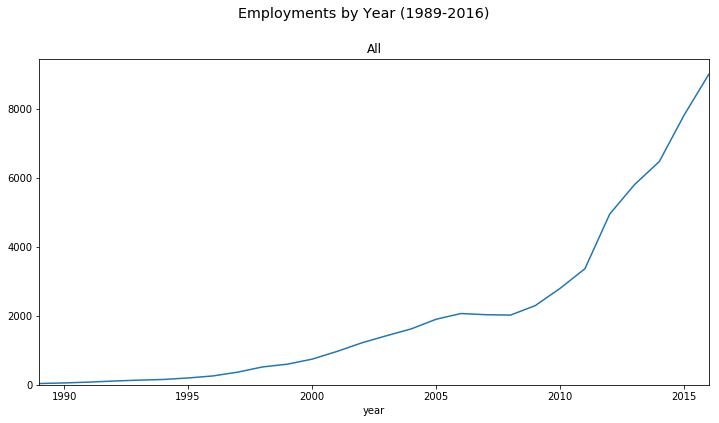

In [22]:
# count_by_years = pd.DataFrame({'count':empl_changes_df.groupby(['ticker','type','year']).size()}).reset_index()
# empl_by_years = count_by_years.groupby(['ticker','type']).apply(
#     lambda df:df.sort_values(['year']).assign(cumsum = lambda df2:df2['count'].cumsum()) # Calculate cumsum.
# ).reset_index(drop=True).pivot_table(
#     index=['ticker','year'],columns='type',values=['cumsum'],fill_value=0 # Reshape to wide format.
# ).assign(
#     employment=lambda df:(df['cumsum']['hiring']-df['cumsum']['firing']-df['cumsum']['leaving']) # Get employment.
# ).drop('cumsum',axis=1).reset_index()
# empl_by_years.columns = empl_by_years.columns.droplevel('type')

# Plot.
for (ticker, col), ax in zip(
    empl_by_years.pivot_table(
        index='year',columns='ticker',values='employment',fill_value=0
    ).loc[lambda df:(df.index>=1989)&(df.index<=2016)].iteritems(),
    iterator_for_axis(fig_func=lambda x:x.suptitle("Employments by Year (1989-2016)",fontsize="x-large",y=1))
):
    col.plot(ax=ax, title=ticker).set_ylim(bottom=0)

plt.show()

## Overall trends.
Note: Plots by year and plots by months do not only differ in frequency, but also in sample size. This is due to the entries without valid month record.

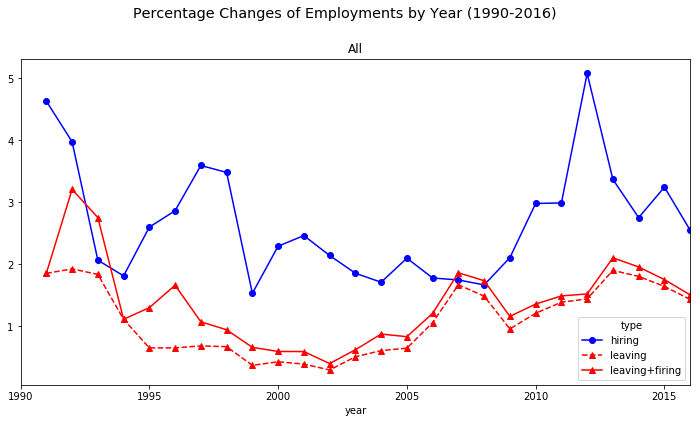

In [23]:
# Count and calculate percentages of employment changes.
prop_by_months = pd.DataFrame(
    {'count':empl_changes_df.groupby(['ticker','type','year','month']).size()} # Count by month.
).reset_index().merge(
    right=empl_by_years.assign(year_1L=lambda df:df.year+1)[['ticker','year_1L','employment']],
    left_on = ['ticker','year'], right_on = ['ticker','year_1L'] # Merge with last year's employment.
).assign(
    prop=lambda df:df['count']/df['employment']*100 # Calculate proportions.
).drop(
    ['count','year_1L','employment'],axis=1 # Drop unnecessary variables.
).loc[lambda df:(df.year>=1991)&(df.year<=2016)] # Keep only [1990, 2016] segment.

# prop_by_months.pivot_table(
#     index = ['ticker','year'], columns = 'type', values = 'prop', fill_value=0
# ).reset_index().assign(
#     **{"leaving+firing":lambda df:df.leaving+df.firing}
# ).drop("firing",axis=1).drop('ticker',axis=1).loc[lambda df:df.year>=xleft].set_index('year').plot(
#     xticks=[1990,1995,2000,2005,2010,2015], xlim=(xleft,2016), style=['b-o','r--^','r-^'],
#     title="Percentage Changes of Employments by Year (1990-2016)", figsize=(12,6)
# )


# Plot by year.
for (ticker, grp), ax, xleft in zip(
    prop_by_months.pivot_table(
        index = ['ticker','year'], columns = 'type', values = 'prop', fill_value=0
    ).reset_index().assign(
        **{"leaving+firing":lambda df:df.leaving+df.firing}
    ).drop("firing",axis=1).groupby('ticker'),
    iterator_for_axis(fig_func=lambda x:x.suptitle("Percentage Changes of Employments by Year (1990-2016)", fontsize="x-large", y=1)),
    xlefts
):
    grp.drop('ticker',axis=1).loc[lambda df:df.year>=xleft].set_index('year').plot(
        ax=ax, title=ticker, xticks=[1990,1995,2000,2005,2010,2015], xlim=(xleft,2016), style=['b-o','r--^','r-^']
    )
plt.show()

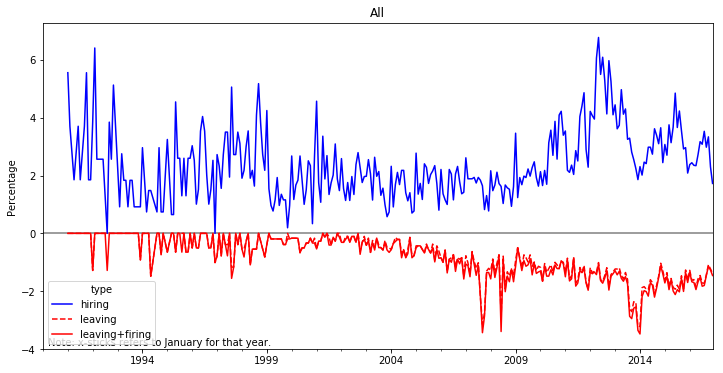

In [24]:
start_year=1990
end_year=2016
for (ticker, grp),ax,xleft in zip(
    prop_by_months.loc[lambda df:(df.month!=0)&(df.year>=start_year)&(df.year<=end_year)].pivot_table(
        index = ['ticker','year','month'], columns='type', values = 'prop', fill_value=0
    ).reset_index().assign(
        **{
            "leaving+firing":lambda df:-(df.leaving+df.firing),
            "leaving":lambda df:-df.leaving,
            "yrmth":lambda df:pd.PeriodIndex(year=df.year,month=df.month,freq='M')
        }
    ).set_index('yrmth').groupby('ticker'),
    iterator_for_axis(), xlefts
):
    grp.loc[lambda df:df.year>=xleft][['hiring','leaving','leaving+firing']].plot(
        ax=ax,title=ticker,style=['b-','r--','r-'],
        xlim=(pd.Period('{}-01'.format(xleft)),pd.Period('{}-12'.format(2016))),
        #xticks=[pd.Period('{}-01'.format(int(x*5+1990))) for x in range(5)]
    )
    ax.set_ylabel('Percentage')
    ax.set_xlabel('')
    ax.hlines(0,pd.Period('{}-01'.format(xleft)),pd.Period('{}-12'.format(2016)),colors='tab:gray')
    ax.annotate("Note: x-sticks refers to January for that year.",(5,3),xycoords="axes points")
plt.show()

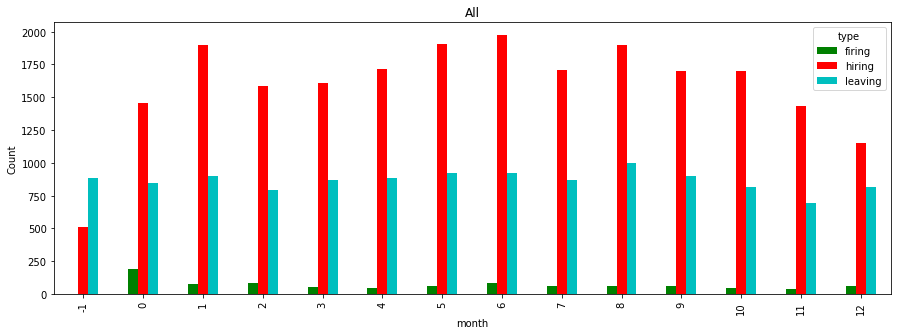

In [25]:
# Month composition.
display(HTML("<center><strong>Month Composition (-1: None, 0: Invalid month)</strong></center>"))
for idx, grp in empl_changes_df.groupby(['ticker']):
    grp.assign(count=1).pivot_table(
        index = 'month', columns = 'type', values='count', aggfunc='sum', fill_value=0
    ).plot.bar(figsize=(15,5),color=color_styles,title=idx).set_ylabel("Count")
    plt.show()

## By birth group.
Note: Birth year `2000` seems to be a trash bin for problematic records and thus will be treated the same as `None`.

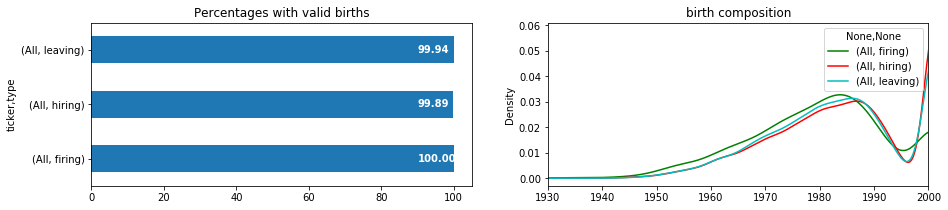

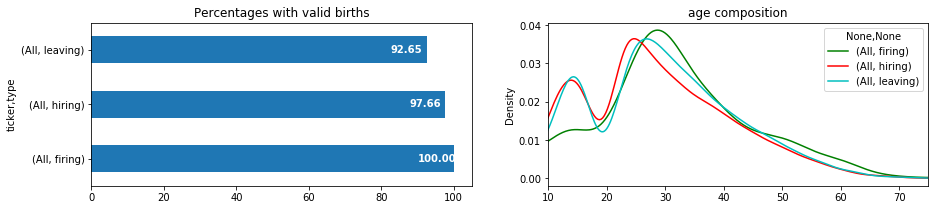

In [26]:
birth_df = empl_changes_df[['ticker','type','year','birth']]
birth_df = birth_df.assign(
    birth = lambda df:df.birth.apply(lambda x:int(x) if x not in ['2000','None'] else np.nan),
    age = lambda df:(df.year-df.birth)
)

# Define a routine to generate plots.
var, xlim = "birth", (1930,2000)
for ticker, grp in birth_df.groupby('ticker'):
    plt.subplots(1,2,figsize=(15,3))
    plt.subplot(121)
    to_plot = grp.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(grp.loc[~grp[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="{} composition".format(var),color=color,legend=True)
    plt.show()
var, xlim = "age", (10,75)
for ticker, grp in birth_df.groupby('ticker'):
    plt.subplots(1,2,figsize=(15,3))
    plt.subplot(121)
    to_plot = grp.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(grp.loc[~grp[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="{} composition".format(var),color=color,legend=True)
    plt.show()

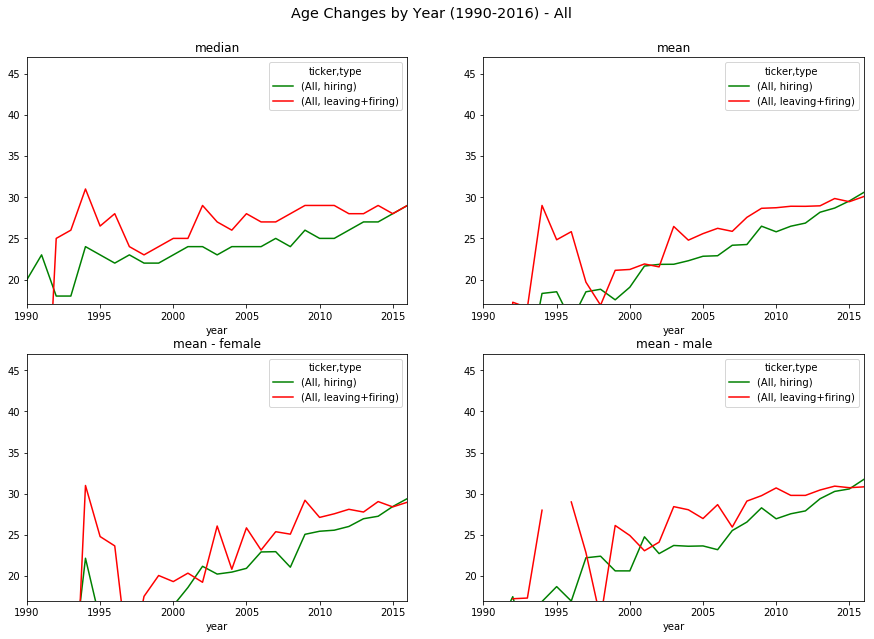

In [27]:
# Age changes by year.
for (ticker, grp), xleft in zip(
    birth_df.replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby('ticker'),
    xlefts
):
    fig, ((ax11, ax12), (ax21, ax22))=plt.subplots(2,2,figsize=(15,10))
    fig.suptitle('Age Changes by Year (1990-2016) - {}'.format(ticker),fontsize='x-large',y=0.95)
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='median'
    ).plot(xlim=(xleft,2016),ylim=(17,47),color=color_styles,ax=ax11,title='median')
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='mean'
    ).plot(xlim=(xleft,2016),ylim=(17,47),color=color_styles,ax=ax12,title='mean')
    grp.loc[empl_changes_df.gender=='1'].pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='mean'
    ).plot(xlim=(xleft,2016),ylim=(17,47),color=color_styles,ax=ax21,title='mean - female')
    grp.loc[empl_changes_df.gender=='2'].pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='mean'
    ).plot(xlim=(xleft,2016),ylim=(17,47),color=color_styles,ax=ax22,title='mean - male')
    plt.show()

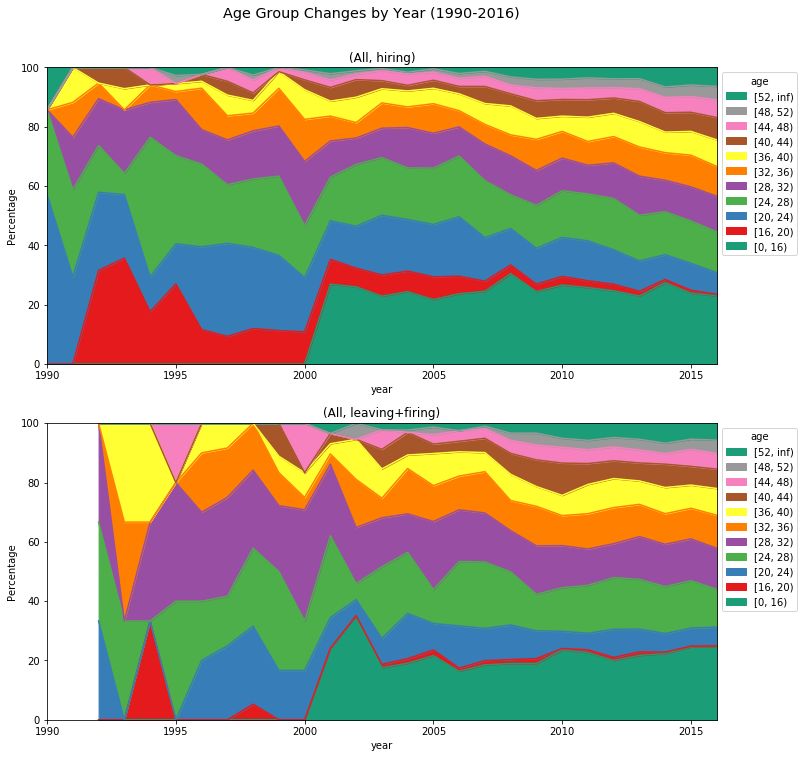

In [28]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','age']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=lambda x:x.suptitle("Age Group Changes by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=pd.cut(grp.age, bins, right=False, labels=False), values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),xlim=(xleft,2016),
        color=[colormap_unif[int(float(i))] for i in to_plot.columns],
        xticks=[1990,1995,2000,2005,2010,2015]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title='age'
    )
plt.show()

## By Gender.

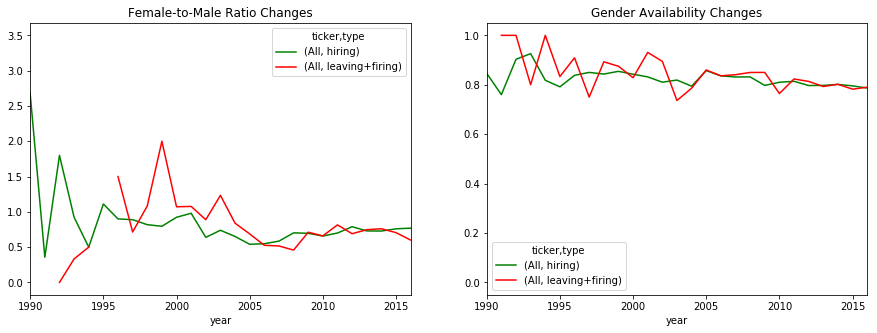

In [29]:
for (ticker, grp), xleft in zip(
    empl_changes_df.replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby('ticker'),
    xlefts
):
    fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='gender',
        aggfunc=lambda x:((x=='1').sum()/(x=='2').sum() if (x=='2').sum() else np.nan)
    ).plot(
        xlim=(xleft,2016),color=color_styles,title="Female-to-Male Ratio Changes",ax=ax1,
        xticks=[1990+5*x for x in range(6)]
    )
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='gender',
        aggfunc=lambda x:((x!='0').sum()/x.size)
    ).plot(
        xlim=(xleft,2016),color=color_styles,title="Gender Availability Changes",ax=ax2,
        xticks=[1990+5*x for x in range(6)]
    )
    plt.show()

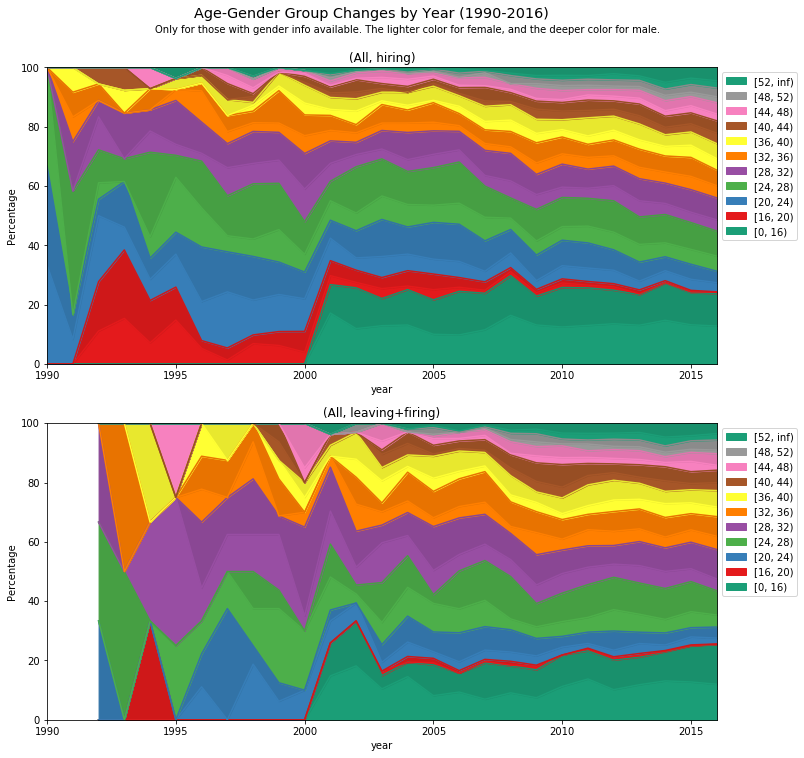

In [30]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
def fig_func(fig):
    fig.suptitle("Age-Gender Group Changes by Year (1990-2016)", fontsize='x-large', y=0.95)
    fig.text(0.25,0.92,
          "Only for those with gender info available. The lighter color for female, and the deeper color for male.")
for (idx, grp), ax, xleft in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(empl_changes_df.gender!='0'), ['ticker','type','year','age']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=fig_func
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=[pd.cut(grp.age, bins, right=False, labels=False), empl_changes_df.gender], 
        values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""), 
        xlim=(xleft,2016), xticks=[1990+5*x for x in range(6)],
        color=[
            colormap_unif[int(float(i))] if j=='1' else tuple(t/1.1 for t in colormap_unif[int(float(i))]) 
            for i,j in to_plot.columns
        ]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed([handles[i] for i in range(len(handles)) if i%2==0]), 
        reversed(["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in
            [re.match(r"\((\d+)\.0",labels[i]).group(1) for i in range(len(labels)) if i%2==0]
        ]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Primary Skill.

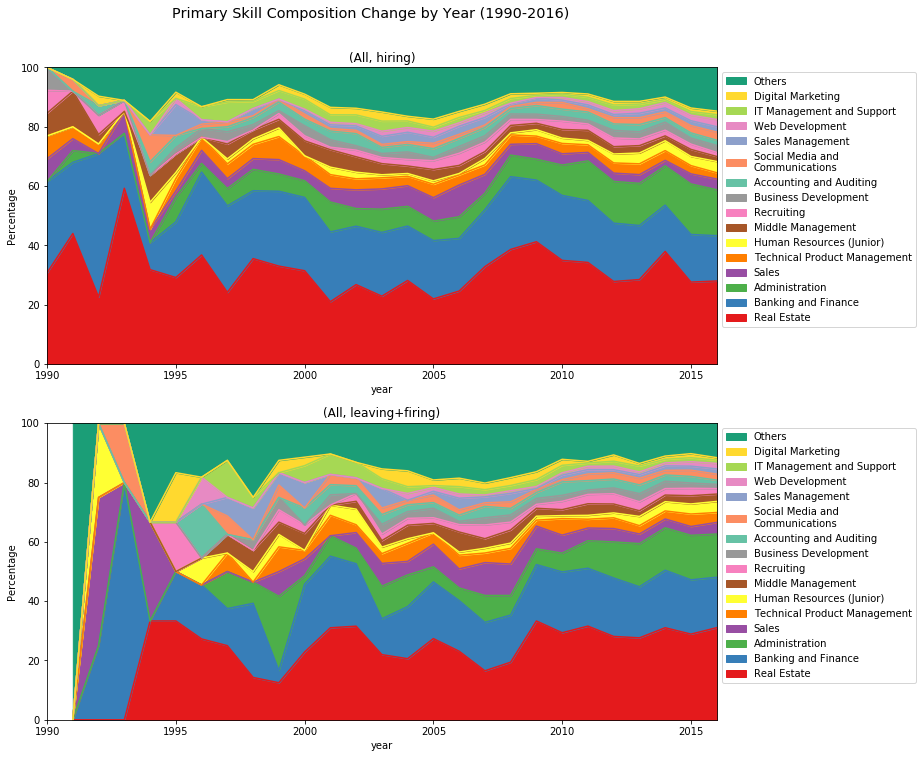

In [31]:
# Create a uniform colormap for all subplots.
skill1_ord_unif = empl_changes_df.groupby('skill1').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill1_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# fig.suptitle("Secondary Skill Composition",fontsize='x-large')
# for (idx,col),ax in zip(
#     empl_changes_df.loc[:].pivot_table(
#         index='skill1',columns=['ticker','type'],values='gender',aggfunc='count'
#     ).iteritems(), itertools.chain.from_iterable(axs)
# ):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:18]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     ax=to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,
#         colors = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill1']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=lambda x:x.suptitle("Primary Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(
        skill1_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill1_ord_unif)}[x] for x in df.skill1
        ], count = 1
    ).pivot_table(
        index='year', columns='skill1_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = [skill1_ord_unif[i] if i<N_cats else "Others" for i in to_plot.columns]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'",""), 
        xlim=(xleft,2016), xticks=[1990,1995,2000,2005,2010,2015]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

In [32]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}

# Find representative profiles.
for i in range(5):
    display(HTML("<strong>"+skill1_ord_unif[i]+"</strong>"))
    to_plot = empl_changes_df.assign(edu=lambda df:df.edu.apply(lambda x:edu_lablst[int(x)])).loc[
        lambda df:(df.skill1==skill1_ord_unif[i]),
        ["job_role","depmt","edu","f_elite"]
    ]
    N = to_plot.shape[0]
    # Job role.
    varname = "job_role"
    top10_job_role = pd.DataFrame([v
        for w in to_plot.groupby(varname).size().reset_index().apply(
        lambda x:[[x[varname].split(',')[0].title(),x[0]]]
        #lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N*100).apply(round,ndigits=2)
    ).reset_index(drop=True)#.drop("count",axis=1)
    # Department.
    varname = "depmt"
    to_plot_depmt = to_plot.loc[lambda df:df[varname]!='']
    N_depmt = to_plot_depmt.shape[0]
    top10_depmt = pd.DataFrame([v
        for w in to_plot_depmt.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).replace(
        {varname:{"Tehnology":"Technology"}}
    ).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N_depmt*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Education.
    top10_edu = to_plot.groupby("edu").size().sort_values(ascending=False).apply(
        lambda x:round(x/N*100,2)).rename("prop").reset_index()
    # show.
    display(HTML("<em>Top 10 entries for each variables with proportions:</em>"))
    display(pd.concat([top10_job_role,top10_depmt,top10_edu], axis=1))
    # Some examples.
    to_plot = to_plot.sample(30)
    display(HTML("<em>Some examples:</em>"))
    display(to_plot)
    

,job_role,count,prop,depmt,prop,edu,prop
0,Mortgage Loan Officer,423,3.91,Accounting,78.56,None/Unknown,43.59
1,Loan Officer,415,3.84,Marketing,10.24,Bachelors,42.47
2,Senior Loan Officer,390,3.60,Operations,3.21,Associates,5.51
3,Account Executive,378,3.49,Production,2.56,High school,3.78
4,Branch Manager,370,3.42,Oversight,2.08,MBA,1.73
5,Mortgage Banker,316,2.92,Business,2.04,Masters excl. MBA,1.71
6,Loan Consultant,313,2.89,Hr,0.80,Vocational degree,0.79
7,Mortgage Loan Originator,253,2.34,Technology,0.25,Doctorate (PhD/JD/MD),0.43
8,Sales Manager,222,2.05,Legal,0.15,NaN,NaN
9,Mortgage Advisor,165,1.52,Management,0.11,NaN,NaN


,job_role,depmt,edu,f_elite
26781,"Mortgage Loan Officer,loan officer",ACCOUNTING,Bachelors,False
20184,"Area Sales Manager,area sales manager",MARKETING,None/Unknown,False
19494,"Loan Consultant | NMLS #514828,consultant",ACCOUNTING,None/Unknown,False
14262,"Licensed Lending Officer (NMLS# 1407395),officer",,None/Unknown,False
7073,"Branch Manager,branch manager",,Bachelors,False
5569,"Portfolio Underwriter,underwriter",,None/Unknown,False
21164,"Senior Mortgage Consultant,senior,consultant",ACCOUNTING,Bachelors,False
3749,"Sr Mortgage Loan Officer,loan officer,senior",ACCOUNTING,Bachelors,False
34009,"Loan Coordinator,coordinator",ACCOUNTING,None/Unknown,False
28680,"Loan Officer,loan officer",ACCOUNTING,Bachelors,False


,job_role,count,prop,depmt,prop,edu,prop
0,Mortgage Banker,212,3.41,Accounting,65.00,Bachelors,45.93
1,Mortgage Loan Officer,117,1.88,Marketing,9.58,None/Unknown,35.89
2,Underwriter,117,1.88,Oversight,7.02,Associates,5.43
3,Branch Manager,111,1.78,Operations,5.92,MBA,5.33
4,Loan Processor,105,1.69,Business,4.45,High school,2.91
5,Account Executive,104,1.67,Production,3.37,Masters excl. MBA,2.83
6,Loan Officer,101,1.62,Technology,1.81,Doctorate (PhD/JD/MD),1.09
7,Mortgage Loan Processor,92,1.48,Hr,1.62,Vocational degree,0.59
8,Mortgage Underwriter,70,1.12,Legal,0.79,NaN,NaN
9,Mortgage Loan Originator,67,1.08,Management,0.42,NaN,NaN


,job_role,depmt,edu,f_elite
14694,"Mortgage Consultant,consultant",ACCOUNTING,Bachelors,False
31073,"Executive Vice President,vice president,executive",,MBA,False
5607,"QC Auditor,quality control,auditor",PRODUCTION,None/Unknown,False
17615,"Home Mortgage Consultant,home,consultant",ACCOUNTING,None/Unknown,False
19982,"Mortgage Underwriter,underwriter",ACCOUNTING,None/Unknown,False
6283,"Portfolio Investment Professional,professional",ACCOUNTING,MBA,False
33774,"Sr. Loan Processor,loan processor,senior",ACCOUNTING,None/Unknown,False
12246,"Mortgage Professional,professional",ACCOUNTING,Bachelors,False
638,"Mortgage Sales Consultant,sales consultant","ACCOUNTING,MARKETING",Associates,False
11059,"Post Closing Underwriter III,underwriter,3",,Bachelors,False


,job_role,count,prop,depmt,prop,edu,prop
0,Mortgage Banker,404,8.91,Accounting,63.76,Bachelors,60.15
1,Mortgage Loan Officer,88,1.94,Marketing,14.19,None/Unknown,18.73
2,Mortgage Loan Originator,76,1.68,Operations,6.79,Associates,7.39
3,Associate Banker,71,1.57,Hr,3.70,Masters excl. MBA,5.58
4,Vendor Analyst,63,1.39,Production,3.66,High school,4.32
5,Administrative Assistant,58,1.28,Business,2.29,MBA,2.36
6,Power Banker,54,1.19,Oversight,2.03,Vocational degree,1.01
7,Production Assistant,53,1.17,Technology,1.92,Doctorate (PhD/JD/MD),0.46
8,Client Care Specialist,53,1.17,Legal,1.09,NaN,NaN
9,Loan Processor,52,1.15,Management,0.57,NaN,NaN


,job_role,depmt,edu,f_elite
20463,"Senior Government Mortgage Underwriter,senior,government,underwriter",ACCOUNTING,None/Unknown,False
33648,"Mortgage Banker,banker",ACCOUNTING,Bachelors,False
32538,"Mortgage Banker,banker",ACCOUNTING,Bachelors,False
13856,"Foreclosure Specialist,specialist",,Bachelors,False
225,"Associate Vice President for Corporate Strategy & Development,vice president,associate,development","MANAGEMENT,BUSINESS",Bachelors,False
30956,"Web Banker,web,banker",TECHNOLOGY,MBA,False
1626,"Loss Mitigation Specialist,specialist",,Bachelors,False
5191,"Call Center Representative,call center,representative",,High school,False
24460,Loan Setup,ACCOUNTING,Bachelors,False
29036,"Senior Mortgage Banker,senior,banker",ACCOUNTING,Bachelors,False


,job_role,count,prop,depmt,prop,edu,prop
0,Mortgage Banker,186,13.29,Accounting,73.41,Bachelors,55.64
1,Account Executive,105,7.50,Marketing,14.25,None/Unknown,26.14
2,Mortgage Loan Officer,58,4.14,Operations,3.62,Associates,7.50
3,Loan Officer,58,4.14,Business,2.14,High school,4.50
4,Branch Manager,32,2.29,Oversight,2.07,Masters excl. MBA,2.93
5,Senior Mortgage Banker,30,2.14,Production,1.72,MBA,2.57
6,Mortgage Loan Originator,30,2.14,Hr,1.67,Vocational degree,0.64
7,Senior Loan Officer,27,1.93,Technology,1.11,Doctorate (PhD/JD/MD),0.07
8,Executive Mortgage Banker,27,1.93,NaN,NaN,NaN,NaN
9,Sales Manager,20,1.43,NaN,NaN,NaN,NaN


,job_role,depmt,edu,f_elite
2782,"Licensed Lending Officer,officer",,Bachelors,False
10088,"Senior Mortgage Banker,senior,banker",ACCOUNTING,None/Unknown,False
27824,"Assistant Sales Manager,sales manager,assistant",MARKETING,Bachelors,False
22330,"Sr. Account Executive,account executive,senior",,Bachelors,False
2843,"Founders Club Mortgage Banker,banker",ACCOUNTING,Bachelors,False
13972,"Associate Banker,associate,banker",,Bachelors,False
11033,"Mortgage Banker,banker",ACCOUNTING,None/Unknown,False
24929,"Senior Client Advocate,senior,client,advocate",,Bachelors,False
26838,"Mortgage Processor,processor",ACCOUNTING,MBA,False
19528,"Mortgage Loan Officer,loan officer",ACCOUNTING,None/Unknown,False


,job_role,count,prop,depmt,prop,edu,prop
0,Business Analyst,50,4.76,Technology,34.72,Bachelors,49.00
1,Senior Business Analyst,29,2.76,Accounting,19.60,None/Unknown,24.74
2,Project Manager,26,2.47,Business,17.33,Masters excl. MBA,13.61
3,Software Engineer,15,1.43,Operations,9.25,MBA,6.95
4,Business Systems Analyst,11,1.05,Production,5.20,Associates,3.14
5,Systems Analyst,10,0.95,Marketing,4.62,High school,1.14
6,Business Operations Analyst,9,0.86,Oversight,4.15,Doctorate (PhD/JD/MD),1.05
7,Data Analyst,9,0.86,Hr,3.40,Vocational degree,0.38
8,Senior Project Manager,9,0.86,Legal,1.33,NaN,NaN
9,It Project Manager,8,0.76,Management,0.40,NaN,NaN


,job_role,depmt,edu,f_elite
17345,"Project Coordinator/Business Analyst,project,analyst",,Masters excl. MBA,False
33099,"Business Analyst,business analyst",,None/Unknown,False
23988,"Project Manager,project manager",,Bachelors,False
32408,"Credit and Reporting Analyst,analyst",ACCOUNTING,Masters excl. MBA,False
3692,"Foreclosure Manager,manager",,None/Unknown,False
6588,"Vice President - Originations Technology,vice president",TECHNOLOGY,None/Unknown,False
33732,"Systems Analyst III / Scrum Master / Team Lead,systems analyst,team lead,3,master",TECHNOLOGY,Bachelors,False
5514,"Sr IT Business Analyst,business analyst,senior,it",TECHNOLOGY,None/Unknown,False
31119,"Senior Technical Writer,technical writer,senior",,Bachelors,False
30767,"Agile Coach,coach",,Masters excl. MBA,False


## By Secondary Skill.
Only for those with their primary skill of "Banking and Finance".

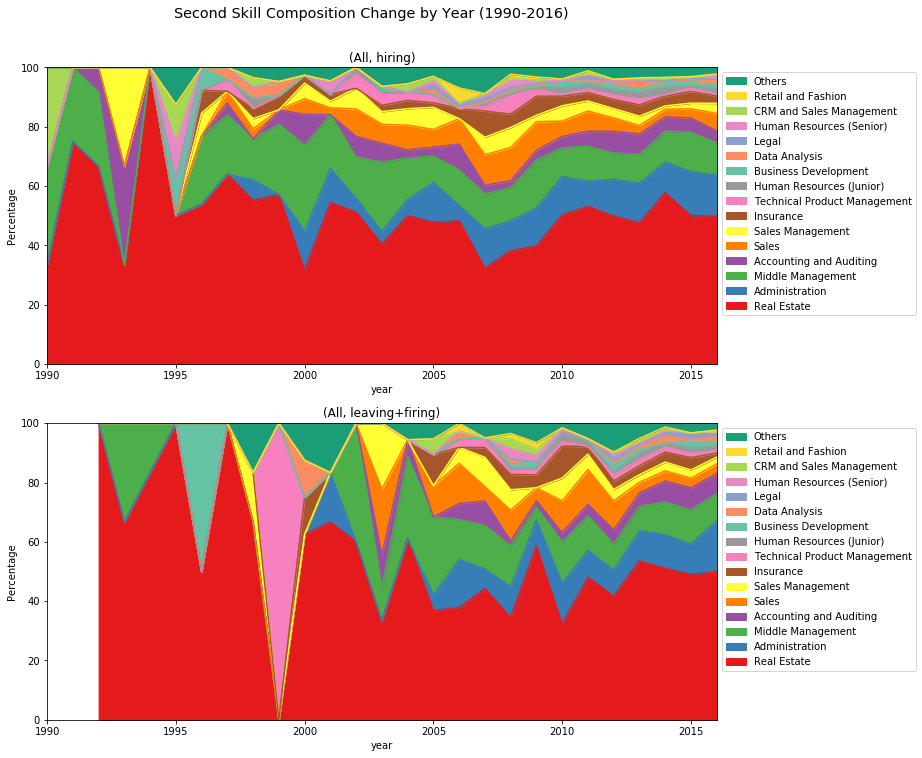

In [33]:
skill2_to_plot = empl_changes_df.loc[lambda df:(df.skill2!='')&(df.skill1=="Banking and Finance")]

# Create a uniform colormap for all subplots.
skill2_ord_unif = skill2_to_plot.groupby('skill2').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill2_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# fig.suptitle("Secondary Skill Composition",fontsize='x-large')
# for (idx,col),ax in zip(
#     skill2_to_plot.loc[:].pivot_table(
#         index='skill2',columns=['ticker','type'],values='gender',aggfunc='count'
#     ).iteritems(), itertools.chain.from_iterable(axs)
# ):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:18]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     ax=to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,
#         colors = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    skill2_to_plot.loc[lambda df:df.skill2!=''].loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill2']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=lambda x:x.suptitle("Second Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(
        skill2_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill2_ord_unif)}[x] for x in df.skill2
        ], count = 1
    ).pivot_table(
        index='year', columns='skill2_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = [skill2_ord_unif[i] if i<N_cats else "Others" for i in to_plot.columns]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'",""), 
        xlim=(xleft,2016), xticks=[1990,1995,2000,2005,2010,2015]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

In [34]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}

# Find representative profiles.
for i in range(5):
    display(HTML("<strong>"+skill2_ord_unif[i]+"</strong>"))
    to_plot = skill2_to_plot.assign(edu=lambda df:df.edu.apply(lambda x:edu_lablst[int(x)])).loc[
        lambda df:(df.skill2==skill2_ord_unif[i]),
        ["job_role","depmt","edu","f_elite"]
    ]
    N = to_plot.shape[0]
    # Job role.
    varname = "job_role"
    top10_job_role = pd.DataFrame([v
        for w in to_plot.groupby(varname).size().reset_index().apply(
        lambda x:[[x[varname].split(',')[0].title(),x[0]]]
        #lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N*100).apply(round,ndigits=2)
    ).reset_index(drop=True)#.drop("count",axis=1)
    # Department.
    varname = "depmt"
    to_plot_depmt = to_plot.loc[lambda df:df[varname]!='']
    N_depmt = to_plot_depmt.shape[0]
    top10_depmt = pd.DataFrame([v
        for w in to_plot_depmt.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N_depmt*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Education.
    top10_edu = to_plot.groupby("edu").size().sort_values(ascending=False).apply(
        lambda x:round(x/N*100,2)).rename("prop").reset_index()
    # show.
    display(HTML("<em>Top 10 entries for each variables with proportions:</em>"))
    display(pd.concat([top10_job_role,top10_depmt,top10_edu], axis=1))
    # Some examples.
    to_plot = to_plot.sample(30).assign(
        job_role=lambda df:df.job_role.apply(lambda x:x.split(",")[0])
    )
    display(HTML("<em>Some examples:</em>"))
    display(to_plot)
    

,job_role,count,prop,depmt,prop,edu,prop
0,Underwriter,67,2.71,Accounting,68.33,Bachelors,46.83
1,Mortgage Loan Processor,66,2.67,Marketing,9.76,None/Unknown,40.07
2,Mortgage Banker,61,2.47,Operations,6.26,Associates,4.41
3,Mortgage Loan Officer,57,2.30,Oversight,5.37,High school,3.44
4,Account Executive,51,2.06,Production,3.70,MBA,2.10
5,Loan Officer,50,2.02,Business,3.28,Masters excl. MBA,1.66
6,Loan Processor,44,1.78,Hr,1.01,Doctorate (PhD/JD/MD),0.77
7,Loan Consultant,43,1.74,Legal,0.95,Vocational degree,0.73
8,Mortgage Underwriter,40,1.62,Technology,0.91,NaN,NaN
9,Branch Manager,36,1.46,Management,0.43,NaN,NaN


,job_role,depmt,edu,f_elite
7723,AVP Risk,OVERSIGHT,Bachelors,False
10798,Loan Officer,ACCOUNTING,Bachelors,False
14905,Mortgage Loan Officer,ACCOUNTING,None/Unknown,False
11959,Account Executive,,Bachelors,False
16543,Branch Manager,,Bachelors,False
14864,Setup Compliance/Closing Coordinator Specialist,,None/Unknown,False
8432,Underwriter II Processor Post-Closer/Loan Defect Resolutions,,None/Unknown,False
29405,Home Loan Specialist,ACCOUNTING,None/Unknown,False
859,Mortgage Banker,ACCOUNTING,None/Unknown,False
24066,Mortgage Advisor,ACCOUNTING,None/Unknown,False


,job_role,count,prop,depmt,prop,edu,prop
0,Mortgage Banker,40,6.97,Accounting,73.19,Bachelors,51.39
1,Loan Processor,13,2.26,Marketing,9.41,None/Unknown,32.40
2,Underwriter,13,2.26,Oversight,4.36,Associates,8.19
3,Account Executive,12,2.09,Operations,3.90,High school,2.96
4,Senior Mortgage Banker,11,1.92,Business,2.57,MBA,2.61
5,Loan Counselor,7,1.22,Production,2.57,Masters excl. MBA,1.39
6,Customer Service Representative,7,1.22,Hr,1.93,Vocational degree,0.87
7,Business Analyst,7,1.22,Technology,1.24,Doctorate (PhD/JD/MD),0.17
8,Mortgage Loan Processor,6,1.05,Legal,0.83,NaN,NaN
9,Closing Coordinator,5,0.87,NaN,NaN,NaN,NaN


,job_role,depmt,edu,f_elite
31353,Jr Mortgage Banker,ACCOUNTING,None/Unknown,False
16603,Investor Reporting Analyst,ACCOUNTING,Bachelors,False
15139,Director of Mortgage Banking,"ACCOUNTING,OVERSIGHT",Bachelors,False
29175,Loan Officer,ACCOUNTING,Associates,False
25100,Production Assistant | NMLS # : 1425349,PRODUCTION,Associates,False
8271,Underwriter,,None/Unknown,False
32261,Loan Counselor,ACCOUNTING,None/Unknown,False
32114,Retired,,Bachelors,False
6248,Senior Mortgage Banker,ACCOUNTING,Bachelors,False
29754,Quality Assurance Quality Control Analyst,PRODUCTION,Bachelors,False


,job_role,count,prop,depmt,prop,edu,prop
0,Supervisor,9,1.59,Accounting,37.79,Bachelors,45.31
1,Senior Vice President,9,1.59,Operations,17.82,None/Unknown,30.44
2,Manager,8,1.42,Marketing,12.54,MBA,8.32
3,Operations Manager,7,1.24,Oversight,11.44,Associates,6.19
4,Mortgage Professional,7,1.24,Production,5.01,Masters excl. MBA,5.49
5,Business Analyst,7,1.24,Business,4.73,High school,2.12
6,Assistant Vice President,5,0.88,Technology,4.62,Doctorate (PhD/JD/MD),1.59
7,Production Assistant,5,0.88,Hr,3.91,Vocational degree,0.53
8,Underwriter,5,0.88,Management,1.16,NaN,NaN
9,Avp,5,0.88,Legal,0.66,NaN,NaN


,job_role,depmt,edu,f_elite
9477,Business Analyst,,MBA,False
34636,Loan Reconciliation Analyst II,ACCOUNTING,None/Unknown,False
411,VP of Business Development,BUSINESS,Bachelors,False
3700,National Underwriting Manager,,Bachelors,True
28401,Sr. Program Manager,,Bachelors,False
32396,Business Operations Analyst,"OPERATIONS,BUSINESS",None/Unknown,False
24777,Mortgage Planner,ACCOUNTING,None/Unknown,False
31223,Operations Supervisor - Morgan Stanley Home Loans,OPERATIONS,Bachelors,False
8478,Assistant Underwriter,,Bachelors,False
12702,Customer Service,MARKETING,Bachelors,False


,job_role,count,prop,depmt,prop,edu,prop
0,Mortgage Banker,9,3.42,Accounting,71.11,Bachelors,41.44
1,Mortgage Underwriter,6,2.28,Oversight,13.68,None/Unknown,26.62
2,Senior Financial Analyst,6,2.28,Business,4.62,MBA,18.63
3,Vice President,4,1.52,Hr,2.72,Masters excl. MBA,9.89
4,Bankruptcy Specialist,4,1.52,Marketing,2.54,Associates,2.28
5,Underwriter Ii,4,1.52,Operations,2.36,Doctorate (PhD/JD/MD),0.76
6,Financial Analyst,4,1.52,Technology,1.63,Vocational degree,0.38
7,Vice President Of Finance,4,1.52,Production,1.36,NaN,NaN
8,De Underwriter,4,1.52,NaN,NaN,NaN,NaN
9,Senior Investor Reporting Analyst,4,1.52,NaN,NaN,NaN,NaN


,job_role,depmt,edu,f_elite
560,Credit Analyst-Underwriter,ACCOUNTING,None/Unknown,False
119,Vice President,,Bachelors,False
21768,Tax Payment Processorr,ACCOUNTING,Bachelors,False
18530,Accountant,,None/Unknown,False
23852,Bankruptcy Specialist,,Masters excl. MBA,False
33655,Sr. Analyst,,None/Unknown,False
26160,Manager Loan Accounting and Supervisor Accounting,ACCOUNTING,Bachelors,False
25467,Financial Analyst,ACCOUNTING,None/Unknown,False
20809,Senior Financial Analyst,ACCOUNTING,Bachelors,False
31235,Chief Financial Officer,"ACCOUNTING,OVERSIGHT",Doctorate (PhD/JD/MD),False


,job_role,count,prop,depmt,prop,edu,prop
0,Mortgage Banker,21,8.50,Accounting,65.78,Bachelors,53.04
1,Account Executive,13,5.26,Marketing,18.87,None/Unknown,28.74
2,Branch Manager,13,5.26,Operations,3.86,Associates,7.69
3,Loan Officer,8,3.24,Oversight,2.98,MBA,5.26
4,Loan Processor,7,2.83,Hr,2.87,High school,4.05
5,Mortgage Loan Officer,7,2.83,Business,2.65,Masters excl. MBA,1.21
6,Senior Mortgage Banker,6,2.43,Production,2.32,NaN,NaN
7,Mortgage Loan Originator,6,2.43,Technology,0.66,NaN,NaN
8,Personal Banker,4,1.62,NaN,NaN,NaN,NaN
9,Sales Manager,4,1.62,NaN,NaN,NaN,NaN


,job_role,depmt,edu,f_elite
25010,Assistant Branch Manager,,Bachelors,False
23473,Mortgage Loan Originator NMLS# 244407,ACCOUNTING,Bachelors,False
4212,AVP Sales Manager - Broker Direct,MARKETING,Bachelors,False
35258,Loan Officer NMLS#1257333,ACCOUNTING,Bachelors,False
1359,Regional Vice President,,Bachelors,False
10136,Loan Processor,ACCOUNTING,None/Unknown,False
25799,Branch Manager,,Bachelors,False
20413,Default Loan Servicing Manager,ACCOUNTING,Associates,False
11900,Team Sales Manager/Equal Housing Lender,MARKETING,Bachelors,False
34973,Assistant Manager,,Associates,False


## By Country.

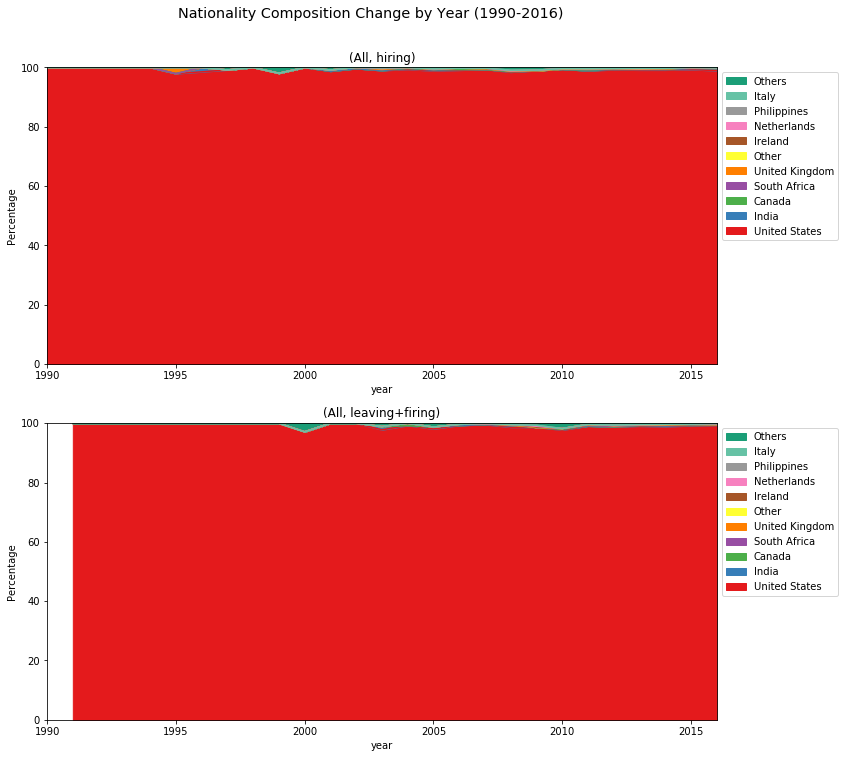

In [35]:
# Create a uniform colormap for all subplots.
cntry_ord_unif = empl_changes_df.groupby('cntry').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    cntry_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='cntry',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:28]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,rotatelabels=True,
#         color = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()


## Continued ##
N_cats = 10 # Number of categories to be shown.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','cntry']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=lambda x:x.suptitle("Nationality Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(
        cntry_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(cntry_ord_unif)}[x] for x in df.cntry
        ], count = 1
    ).pivot_table(
        index='year', columns='cntry_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = [cntry_ord_unif[i] if i<N_cats else "Others" for i in to_plot.columns]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'",""),
        xlim=(xleft,2016),xticks=[1990+x*5 for x in range(6)]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(labels), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Education Level.

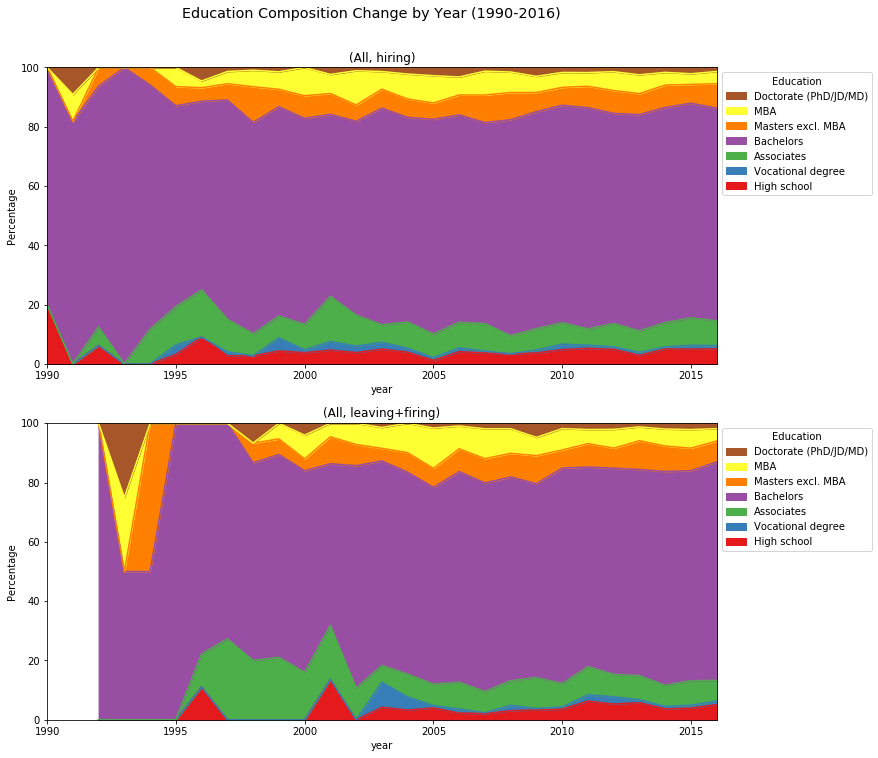

In [36]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}
colormap_unif = {str(idx):clr for idx, clr in zip(
    range(len(edu_lablst)),
    itertools.cycle([plt.get_cmap('Dark2').colors[0]]+list(plt.get_cmap('Set1').colors))
)}

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='edu',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[edu_lablst[x] for x in range(0,8)]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','edu']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2,fig_func=lambda x:x.suptitle("Education Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.loc[lambda df:[int(x)>=f_none_hidden for x in df.edu]].assign(count = 1).pivot_table(
        index='year', columns='edu', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'",""),
        xlim=(xleft,2016), xticks=[1990+x*5 for x in range(6)]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), [edu_lablst[int(x)] for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title="Education"
    )
plt.show()



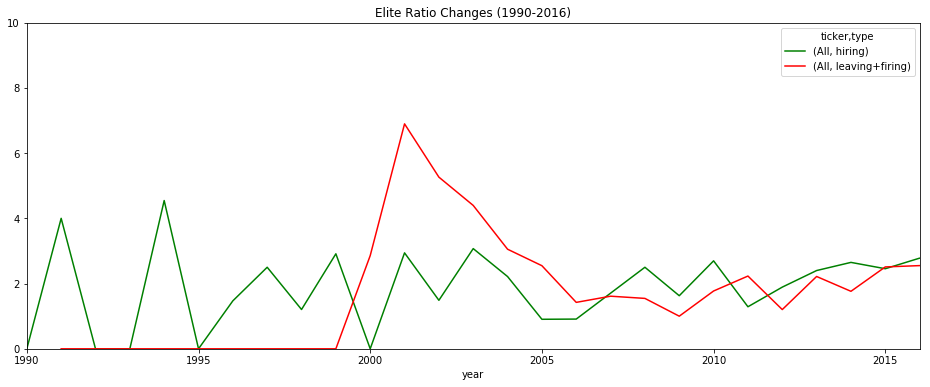

In [37]:
for (ticker, grp), xleft in zip(
    empl_changes_df.replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby('ticker'), xlefts
):
    grp.loc[lambda df:df.year>=xleft].pivot_table(
        index='year',columns=['ticker','type'],values='f_elite',
        aggfunc=lambda x:((x=='True').sum()/(x==x).sum()*100)
    ).plot(
        xlim=(1990,2016),color=color_styles,ylim=(0,10),
        title="Elite Ratio Changes (1990-2016)",figsize=(16,6)
    )
    ax.set_ylabel('Percentage')
plt.show()

# By Next Industry.

Note: Division of 2-digit NAICS's into industry groups are obtained from [Bureau of Labor Statistics](https://www.bls.gov/iag/tgs/iag_index_naics.htm).

In [38]:
NAICS2GRP_dict = {
    '11': (1, "Natural Resources and Mining"),
    '21': (1, "Natural Resources and Mining"),
    '23': (2, "Construction"),
    '31': (3, "Manufacturing"),
    '32': (3, "Manufacturing"),
    '33': (3, "Manufacturing"),
    '42': (4, "Trade, Transportation, and Utilities"),
    '44': (4, "Trade, Transportation, and Utilities"),
    '45': (4, "Trade, Transportation, and Utilities"),
    '48': (4, "Trade, Transportation, and Utilities"),
    '49': (4, "Trade, Transportation, and Utilities"),
    '22': (4, "Trade, Transportation, and Utilities"),
    '51': (5, "Information"),
    '52': (6, "Financial Activities"),
    '53': (6, "Financial Activities"),
    '54': (7, "Professional and Business Services"),
    '55': (7, "Professional and Business Services"),
    '56': (7, "Professional and Business Services"),
    '61': (8, "Education and Health Services"),
    '62': (8, "Education and Health Services"),
    '71': (9, "Leisure and Hospitality"),
    '72': (9, "Leisure and Hospitality"),
    '81': (10, "Other Services"),
    '92': (11, "Public Administration"),
    '99': (12, "Unknown/Unclassified"),
    ''  : (12, "Unknown/Unclassified"),
    'MI': (12, "Unknown/Unclassified"),
    '46': (12, "Unknown/Unclassified"),
    'GO': (12, "Unknown/Unclassified")
}

# Show the mappings.
pd.DataFrame(
    [[key, value[0], value[1]] for key,value in NAICS2GRP_dict.items()]
).groupby([1,2])[0].apply(lambda ser:', '.join(ser)).reset_index().drop(1,axis=1).rename(
    {2:"Industry group",0:"NAICS2"},axis=1
)

,Industry group,NAICS2
0,Natural Resources and Mining,"11, 21"
1,Construction,23
2,Manufacturing,"31, 32, 33"
3,"Trade, Transportation, and Utilities","42, 44, 45, 48, 49, 22"
4,Information,51
5,Financial Activities,"52, 53"
6,Professional and Business Services,"54, 55, 56"
7,Education and Health Services,"61, 62"
8,Leisure and Hospitality,"71, 72"
9,Other Services,81


Note: `46` seems to be a wrong NAICS2 code.

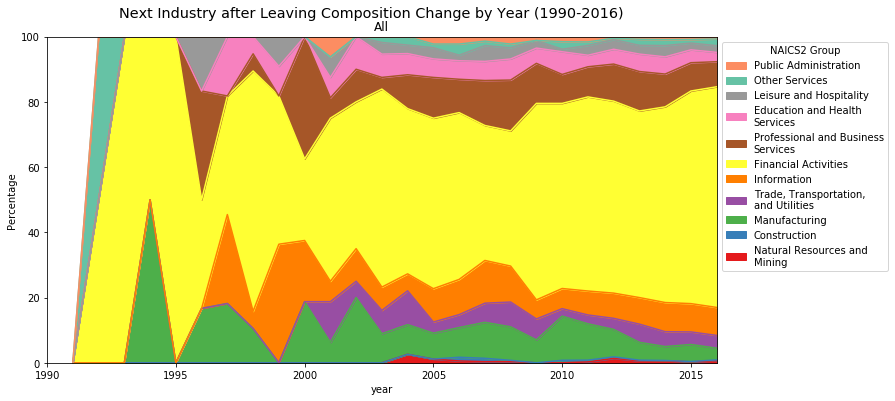

In [39]:
ind_next_lst = sorted(list(set(NAICS2GRP_dict.values())))
colormap_unif = {idx:clr for idx, clr in zip(
    ind_next_lst[:-1], # Assume the last element is "Others".
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif[ind_next_lst[-1]] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(1,2,figsize=(15,7.5))
# for (idx,col),ax in zip(empl_changes_df.loc[lambda df:df.type=='leaving'].pivot_table(
#     index=empl_changes_df.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
#     columns='ticker', values='gender', aggfunc='count'
# ).iteritems(),axs):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[x[1] for x in col.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(df.type=='leaving'), ['ticker','type','year','ind_next']
    ].groupby('ticker'), iterator_for_axis(
        fig_func=lambda x:x.suptitle("Next Industry after Leaving Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), xlefts
):
    to_plot = grp.assign(count=1).pivot_table(
        columns=grp.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
        index='year', values='count', aggfunc='sum', fill_value=0
    )
    if f_none_hidden:
        to_plot.drop(ind_next_lst[-1], axis=1, inplace=True)
    to_plot = to_plot.apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=idx, xlim=(xleft,2016), xticks=[1990,1995,2000,2005,2010,2015]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["\n".join(wrap(re.match(r"\(\d+, (.+)\)",x).group(1),25)) for x in reversed(labels)], 
        loc='upper left', bbox_to_anchor=(1,1), title="NAICS2 Group"
    )
plt.show()

## Tenure and Number of Promotions.

Note:
- Tenure = End date of last entry - Start date of first entry in a consecutive sequence of entries in the same company;
 - When there is any invalid month in the two dates and their years are _not_ the same, the invalid month is replaced by 6;
 - When there is any invalid month in the two dates and their years are the same, the invalid month is assumed to be the extreme value (0 for start and 12 for end) and the results are the minimum of their difference and 6.
- Number of promotions = Number of entries in a consecutive sequence of entries in the same company - 1.

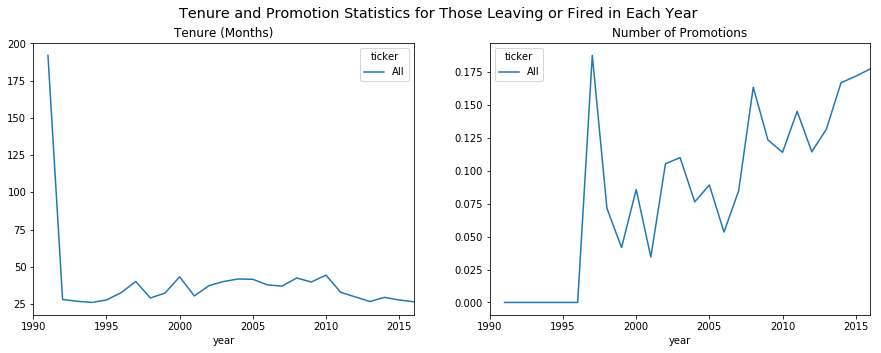

In [40]:
for (ticker, grp), xleft in zip(empl_changes_df.groupby('ticker'),xlefts):
    # Calculate.
    to_plot = grp.loc[lambda df:(df.type!='hiring')&(df.year>=xleft)&(df.year<=2016)].astype(
        {'tenure':'Int64','nprom':'Int64'}
    ).pivot_table(
        columns=['ticker'],index='year',values=['tenure','nprom'],aggfunc=np.nanmean
    )

    # Plot.
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    fig.suptitle("Tenure and Promotion Statistics for Those Leaving or Fired in Each Year",fontsize='x-large')
    to_plot['tenure'].plot(
        title="Tenure (Months)",ax=ax1,xticks=[1990,1995,2000,2005,2010,2015],xlim=(xleft,2016)
    )
    to_plot['nprom'].plot(
        title="Number of Promotions",ax=ax2,xticks=[1990,1995,2000,2005,2010,2015],xlim=(xleft,2016)
    )
plt.show()